In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import sys
sys.path.append('common')

from print_more_stuff import print_more_stuff
from regression_models import dosomething
from pprint import pprint
from preprocessing import mean_and_std

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
outliers_df = pd.read_csv('outliers.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20480 entries, 0 to 20479
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             20480 non-null  float64
 1   bath            20480 non-null  float64
 2   acre_lot        20480 non-null  float64
 3   zip_code        20480 non-null  float64
 4   house_size      20480 non-null  float64
 5   price           20480 non-null  float64
 6   prev_sold_year  20480 non-null  float64
 7   latitude        20480 non-null  float64
 8   longitude       20480 non-null  float64
 9   county          20480 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 1.6 MB


In [4]:
groupby_zipcode = outliers_df.groupby(["zip_code"])["zip_code"].count().sort_values(ascending=False)
groupby_zipcode_df = pd.DataFrame(groupby_zipcode).rename(columns={"zip_code":"count"}).reset_index()
first_zipcode = groupby_zipcode_df.iloc[0]["zip_code"]
first_zipcode

8527.0

In [5]:
one_zipcode_df = outliers_df[outliers_df["zip_code"].isin([first_zipcode])]

In [6]:
one_zipcode_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269 entries, 10338 to 10606
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             269 non-null    float64
 1   bath            269 non-null    float64
 2   acre_lot        269 non-null    float64
 3   zip_code        269 non-null    float64
 4   house_size      269 non-null    float64
 5   price           269 non-null    float64
 6   prev_sold_year  269 non-null    float64
 7   latitude        269 non-null    float64
 8   longitude       269 non-null    float64
 9   county          269 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 23.1 KB


In [7]:
groupby_county = outliers_df.groupby(["county"])["county"].count().sort_values(ascending=False)
groupby_county_df = pd.DataFrame(groupby_county).rename(columns={"county":"count"}).reset_index()
first_county = groupby_county_df.iloc[0]["county"]
first_county

16

In [8]:
one_county_df = outliers_df[outliers_df["county"].isin([first_county])]

In [9]:
one_county_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1721 entries, 13052 to 19278
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             1721 non-null   float64
 1   bath            1721 non-null   float64
 2   acre_lot        1721 non-null   float64
 3   zip_code        1721 non-null   float64
 4   house_size      1721 non-null   float64
 5   price           1721 non-null   float64
 6   prev_sold_year  1721 non-null   float64
 7   latitude        1721 non-null   float64
 8   longitude       1721 non-null   float64
 9   county          1721 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 147.9 KB


In [10]:
# "data":one_zipcode_df,
#  "data":outliers_df,
#  "data":one_county_df,

params = {
    "data":outliers_df,
    "features_a":["prev_sold_year","zip_code","latitude","longitude","county"],
    "features_n":["bed","bath","acre_lot","house_size","price"]
}
normalize_df = mean_and_std(params)
#normalize_df = outliers_df
normalize_df.tail()

,bed,bath,acre_lot,house_size,price,prev_sold_year,zip_code,latitude,longitude,county
20475,0.574501,0.489324,-0.010357,-0.315639,0.095695,2019.0,8886.0,40.687502,-75.101127,19
20476,-0.314758,0.489324,-0.037719,-0.315639,-0.438783,2006.0,8886.0,40.687502,-75.101127,19
20477,-0.314758,-0.449181,-0.033763,-0.315639,-1.124735,2021.0,8886.0,40.687502,-75.101127,19
20478,0.574501,0.489324,-0.031126,-0.315639,-0.191917,2009.0,8886.0,40.687502,-75.101127,19
20479,-0.314758,-0.449181,-0.036730,-0.315639,-1.100528,2020.0,8886.0,40.687502,-75.101127,19


In [11]:
correlation = normalize_df[["latitude","longitude","acre_lot","bed","bath","house_size","prev_sold_year","price"]].corr()
correlation["price"]

latitude          0.118985
longitude         0.270237
acre_lot          0.013009
bed               0.453542
bath              0.618459
house_size        0.361332
prev_sold_year    0.031241
price             1.000000
Name: price, dtype: float64

Text(0.5, 1.0, 'Correlation Between Variables')

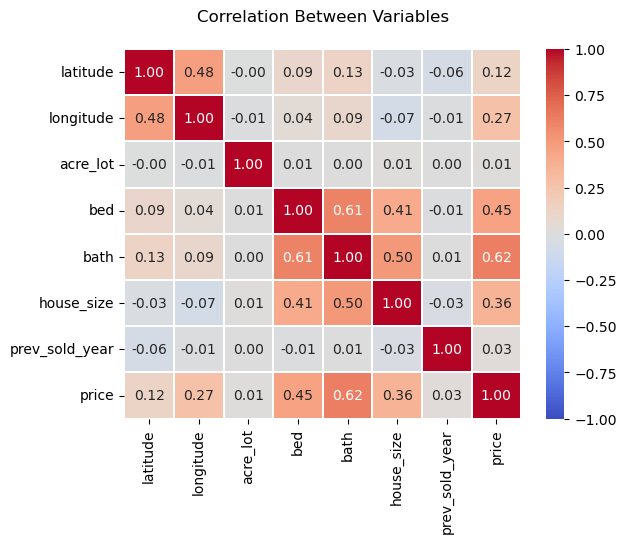

In [12]:
sns.heatmap(correlation, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=0.1)
plt.title("Correlation Between Variables", pad=20)

In [13]:
#corrfeatures = ["latitude","longitude"]
corrfeatures = ["latitude","longitude"]

for feature, value in correlation["price"].items():
    if abs(value) < 0.81 and abs(value) >= 0.17:
        corrfeatures.append(feature)
        
savefeatures = list(dict.fromkeys(corrfeatures))
print(savefeatures)

['latitude', 'longitude', 'bed', 'bath', 'house_size']


In [14]:
pariplot_features = []
for feature, value in correlation["price"].items():
        pariplot_features.append(feature)

In [15]:
features = savefeatures
num_features_to_select = len(features)-1
random_state_value = 42

In [16]:
X = normalize_df[features]
y = normalize_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

In [17]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

In [18]:
def results_dict_append(rtnval):
    results_dict["model"].append(rtnval["model"])
    results_dict["explained variance score"].append(rtnval["explained variance score"])
    results_dict["mae score"].append(rtnval["mae score"])
    results_dict["mse score"].append(rtnval["mse score"])
    results_dict["r2 score"].append(rtnval["r2 score"])
    results_dict["mean fit time"].append(rtnval["mean fit time"])

In [19]:
knn_params = {'n_neighbors': range(20, 25, 1)}
knn_gscv = GridSearchCV(KNeighborsRegressor(), param_grid=knn_params).fit(X, y)

knn_gscv.best_params_

{'n_neighbors': 24}

In [20]:
knn = KNeighborsRegressor(**knn_gscv.best_params_)
knn_gscv = GridSearchCV(knn, param_grid={})
knn_model = knn_gscv.fit(X_train,y_train)
knn_predictions = knn_model.predict(X_test)

In [21]:
pms_config = {
    "title":"KNearest Neighbor", 
    "y_param":y_test, 
    "predictions":knn_predictions, 
    "gscv":knn_gscv
}

In [22]:
results = print_more_stuff(pms_config)

KNearest Neighbor EVS = 0.561283090
KNearest Neighbor MSE = 0.454423
KNearest Neighbor MAE = 0.385425
KNearest Neighbor R2 = 0.560572
KNearest Neighbor Fit Time = 0.008810615539550782


In [23]:
results_dict_append(results)

In [24]:
predict_df = pd.DataFrame(knn_predictions).reset_index()
predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

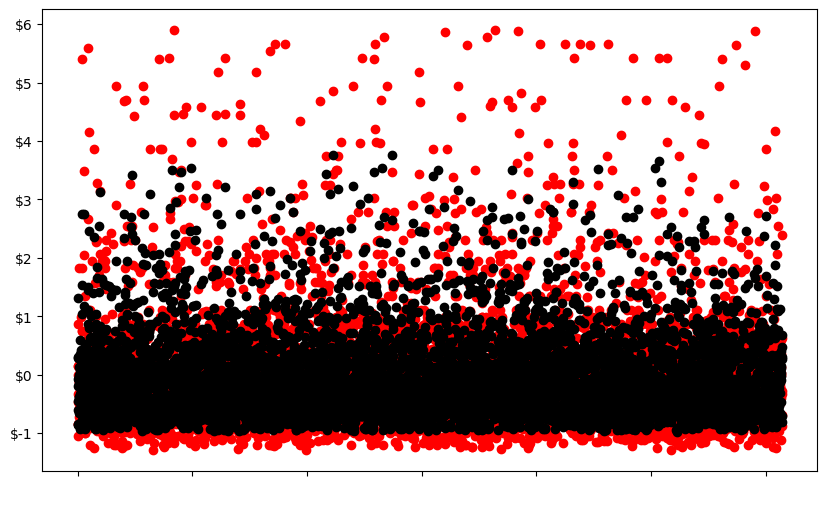

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(predict_df.index,predict_df["prediction"], color="black")
plt.show()

In [26]:
results_dict

{'model': ['KNearest Neighbor'],
 'explained variance score': ['0.561283090'],
 'mae score': ['0.385425'],
 'mse score': ['0.454423'],
 'r2 score': ['0.560572'],
 'mean fit time': [0.008810615539550782]}

In [27]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
KNearest Neighbor,0.561283090,0.385425,0.454423,0.560572,0.008811


In [28]:
not_normlized_features_major = {'model': ['KNearest Neighbor'],
 'explained variance score': ['0.455404097'],
 'mae score': ['183,754.598705'],
 'mse score': ['98,103,056,854.194565'],
 'r2 score': ['0.455047'],
 'mean fit time': [0.004922723770141602]}

not_normlized_features_onecounty = {'model': ['KNearest Neighbor'],
 'explained variance score': ['0.318980040'],
 'mae score': ['93,943.031378'],
 'mse score': ['31,066,266,471.450218'],
 'r2 score': ['0.316227'],
 'mean fit time': [0.0035649776458740235]}

normlized_features_onecounty = {'model': ['KNearest Neighbor'],
 'explained variance score': ['0.360889987'],
 'mae score': ['0.431319'],
 'mse score': ['0.671719'],
 'r2 score': ['0.356049'],
 'mean fit time': [0.0008725166320800781]}

normlized_features_major = {'model': ['KNearest Neighbor'],
 'explained variance score': ['0.579035209'],
 'mae score': ['0.374532'],
 'mse score': ['0.435951'],
 'r2 score': ['0.578434'],
 'mean fit time': [0.002391147613525391]}